In [1]:
import sys
import os

# add project root to path
root = os.path.abspath("..")   # one level up from notebooks/
sys.path.append(root)


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils import load_prices, realized_variance
from src.analysis import get_sim_logreturns, summarize_returns, qq_plot, get_var, get_es

In [3]:
price_data = load_prices("../data/SPY.csv", price_col="Price")
_, log_returns = realized_variance(price_data)

print(len(price_data), len(log_returns))

1256 1255


In [4]:
# if using only a part of all data (e.g. last year)
N = 252
log_returns_cut = log_returns[-N:]

In [6]:
# simulate many paths under one model: GBM
from src.calibration import calibrate_gbm
from src.simulation import simulate_gbm
from src.models import GBMParams

dt = 1/252
T = 1.0
n_paths = 2000
S0 = price_data[-1], # starting price = last observed price in price_data array

mu_hat, sigma_hat = calibrate_gbm(price_data, dt)

gbm_params = GBMParams(
    mu = mu_hat,
    sigma = sigma_hat,
    S0 = S0,
    T=T,
    dt=dt,
    n_paths=n_paths
)

times, S_sim = simulate_gbm(gbm_params, seed=42)
print("S_sim.shape:", S_sim.shape) # (n_steps + 1, n_paths)

S_sim.shape: (253, 2000)


In [ ]:
# simulated log-returns

log_returns_sim = np.diff(np.log(S_sim), axis=0) 
# axis=0 means take diff between each column separately,
# i.e., take diff along time-dimension for each simulated path
print("log_returns_sim.shape:", log_returns_sim.shape) # should be (n_steps, n_paths)

# flatten to 1D in order to build histogram of model-generated daily returns
log_returns_sim_flat = log_returns_sim.ravel() # shape -> (n_steps * n_paths,) = n_steps * n_paths

log_returns_sim.shape: (252, 2000)


NameError: name 'log_returns_sim_flat' is not defined

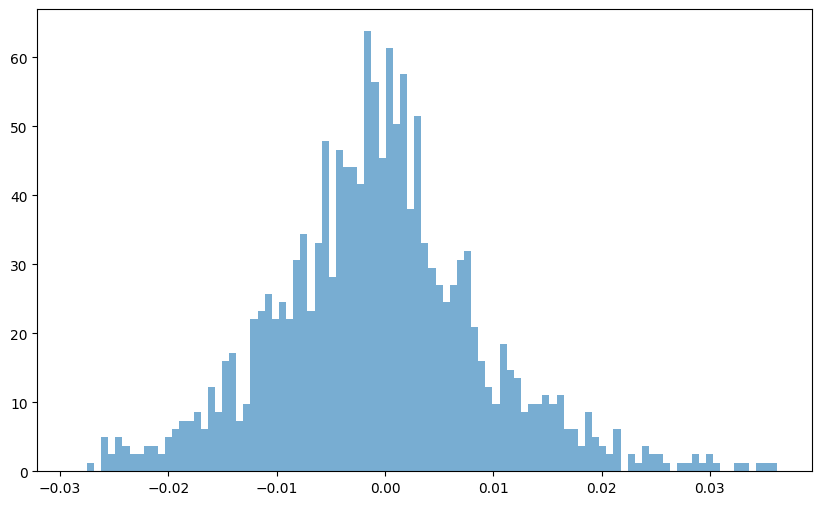

In [5]:
# histogram comparing real log-return distribution with simulated one

plt.figure(figsize=(10,6))

bins = np.linspace(np.percentile(log_returns, 0.5), np.percentile(log_returns, 99.5), 100)
# starts at 0.5th percentile of real returns, ends at 99.5% percentile, 100 = nbr of bins

plt.hist(log_returns, bins=bins, density=True, alpha=0.6, label="real data")
plt.hist(log_returns_sim_flat, bins=bins, density=True, alpha=0.6, label="GBM simulated")
# density = False : y-axis = counts, sum of bar heights = number of samples
# density = True  : area under histogram = 1, plotting estimated PROBABILITY DENSITY FUNC (PDF)
# (want True since comparing real returns vs 0198431093841 simulated points would be meaningless)
# alpha = [0,1] is transparency (0=invisible, 1=fully opaque)

plt.title("daily log-return distributions: real vs GBM")
plt.xlabel("daily log-return")
plt.ylabel("density")
plt.grid(True)
plt.savefig("../plots/log-return_distr_real_vs_gbm.png")

In [6]:
price_data = load_prices("../data/SPY.csv", price_col="Price")
_, log_returns = realized_variance(price_data)
log_returns_lastyear = log_returns[-252:]

log_ret_gbm    = get_sim_logreturns("GBM",    price_data, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_ou     = get_sim_logreturns("OU",     price_data, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_heston = get_sim_logreturns("HESTON", price_data, T=1.0, dt=1/252, n_paths=2000, seed=42)
log_ret_merton = get_sim_logreturns("MERTON", price_data, T=1.0, dt=1/252, n_paths=2000, seed=42)

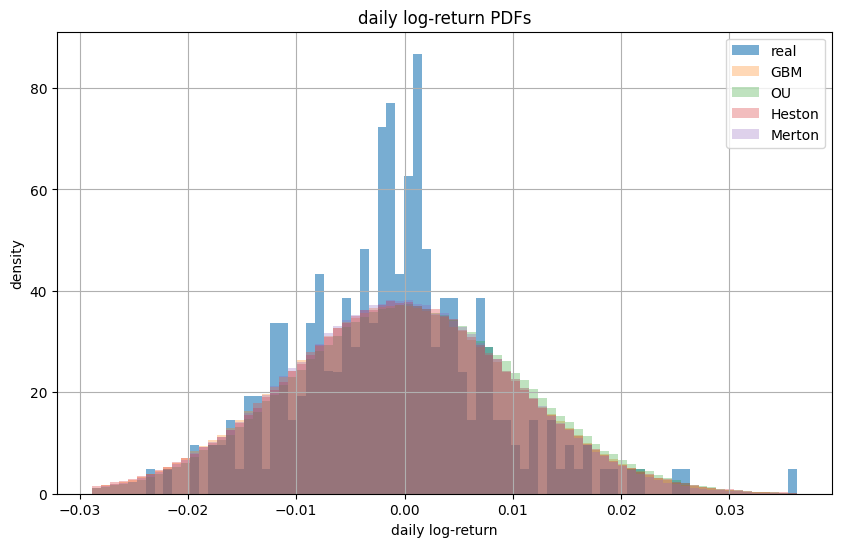

In [7]:
# make model comparison plot

plt.figure(figsize=(10,6))

bins = np.linspace(np.percentile(log_returns, 0.5), np.percentile(log_returns, 99.5), 80)

plt.hist(log_returns_cut, bins=bins, density=True, alpha=0.6, label="real")
plt.hist(log_ret_gbm, bins=bins, density=True, alpha=0.3, label="GBM")
plt.hist(log_ret_ou, bins=bins, density=True, alpha=0.3, label="OU")
plt.hist(log_ret_heston, bins=bins, density=True, alpha=0.3, label="Heston")
plt.hist(log_ret_merton, bins=bins, density=True, alpha=0.3, label="Merton")

plt.title("daily log-return PDFs")
plt.xlabel("daily log-return")
plt.ylabel("density")
plt.legend()
plt.grid(True)
plt.savefig("../plots/log-returnPDFs.png", dpi=200)

In [8]:
# compute summary stats
stats_real   = summarize_returns(log_returns_cut)
stats_gbm    = summarize_returns(log_ret_gbm)
stats_ou     = summarize_returns(log_ret_ou)
stats_heston = summarize_returns(log_ret_heston)
stats_merton = summarize_returns(log_ret_merton)

stats_real

{'mean': np.float64(-0.0010066324573636896),
 'std': np.float64(0.008707646602108318),
 'skew': np.float64(0.4790287664221541),
 'kurtosis': np.float64(4.3221619081135065)}

In [9]:
# table for comparison
import pandas as pd

df_stats = pd.DataFrame({
    "real": stats_real,
    "GMB": stats_gbm,
    "OU": stats_ou,
    "Heston": stats_heston,
    "Merton": stats_merton
})

df_stats
# discuss statistics and their significance in README

,real,GMB,OU,Heston,Merton
mean,-0.001007,-0.000550,0.000195,-0.000531,-0.000606
std,0.008708,0.010788,0.010782,0.010968,0.010779
skew,0.479029,0.003640,0.003415,-0.037793,-0.048339
kurtosis,4.322162,3.006283,3.006427,3.267208,6.584603


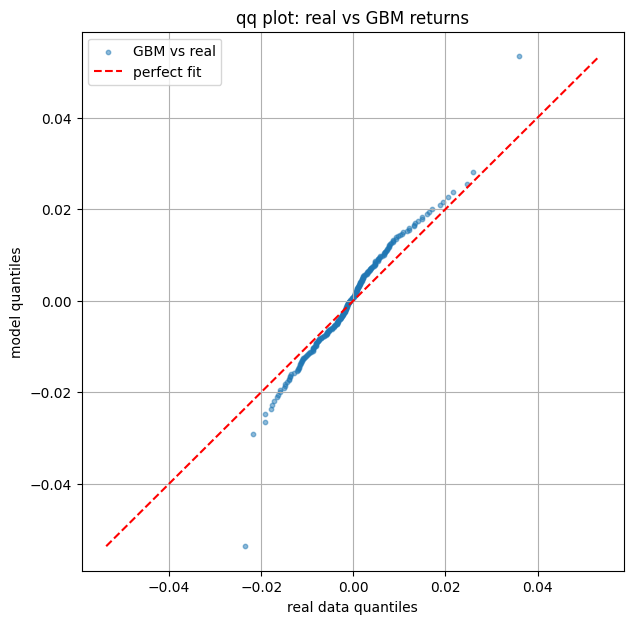

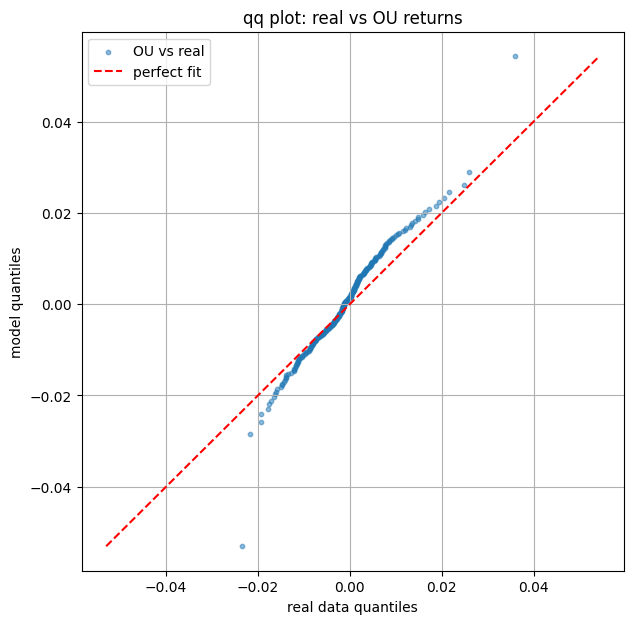

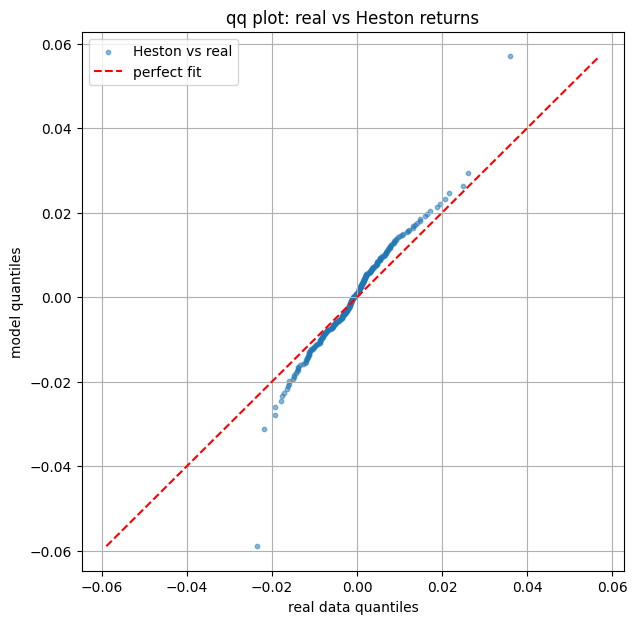

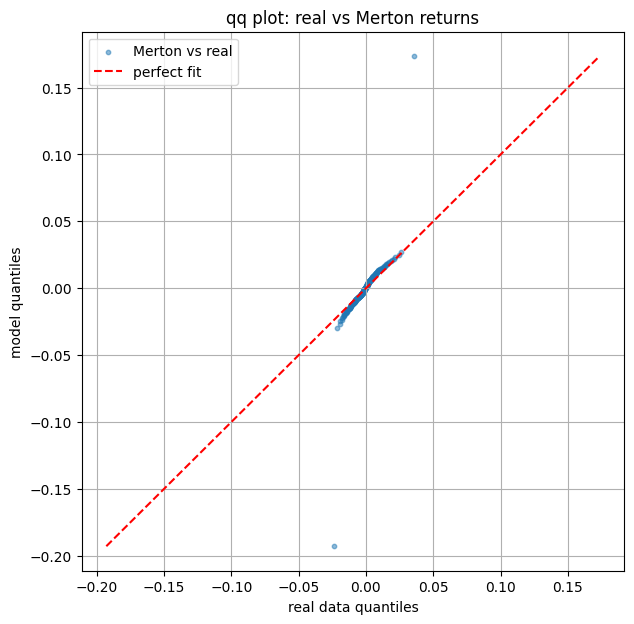

In [10]:
qq_plot(log_returns_cut, log_ret_gbm,    "GBM",    "../plots/qq_gbm.png")
qq_plot(log_returns_cut, log_ret_ou,     "OU",     "../plots/qq_ou.png")
qq_plot(log_returns_cut, log_ret_heston, "Heston", "../plots/qq_heston.png")
qq_plot(log_returns_cut, log_ret_merton, "Merton", "../plots/qq_merton.png")


In [11]:
import numpy as np
import pandas as pd

from src.utils import load_prices, realized_variance
from src.analysis import get_sim_logreturns, summarize_returns, qq_plot

# 1. Load prices and compute real returns
prices = load_prices("../data/SPY.csv", "Price")
_, log_ret_full = realized_variance(prices)

# choose last 252 returns (1 year)
real_returns = log_ret_full[-252:]   # r_real

# 2. Simulated returns from each model (these are also raw returns r_model)
sim_gbm    = get_sim_logreturns("GBM",    prices)
sim_ou     = get_sim_logreturns("OU",     prices)
sim_heston = get_sim_logreturns("Heston", prices)
sim_merton = get_sim_logreturns("Merton", prices)

def standardize(r):
    # convert returns into standardized returns using mean mu and std sigma
    mu_real    = np.mean(real_returns)               # μ_real
    sigma_real = np.std(real_returns, ddof=1)        # σ_real
    r = np.asarray(r)
    return (r - mu_real) / sigma_real           # z = (r - μ_real)/σ_real

z_real    = standardize(real_returns)
z_gbm     = standardize(sim_gbm)
z_ou      = standardize(sim_ou)
z_heston  = standardize(sim_heston)
z_merton  = standardize(sim_merton)


def left_tail_prob(z, k):
    # compute tail probability function P(z < -k)
    z = np.asarray(z)
    return np.mean(z < -k)   # relative frequency of z < -k

ks = [2, 3, 4] # 2sigma, 3sigma, 4sigma events

models = {
    "Real":   z_real,
    "GBM":    z_gbm,
    "OU":     z_ou,
    "Heston": z_heston,
    "Merton": z_merton,
}

rows = []
for k in ks:
    row = {"k": k}
    for name, z in models.items():
        row[name] = left_tail_prob(z, k)   # P(z < -k) for that model
    rows.append(row)

df_tail = pd.DataFrame(rows)
df_tail


,k,Real,GBM,OU,Heston,Merton
0,2,0.015873,0.049063,0.042188,0.052006,0.046422
1,3,0.000000,0.006849,0.005532,0.009530,0.006904
2,4,0.000000,0.000514,0.000427,0.001417,0.001096


In [12]:
import pandas as pd

alphas = [0.95, 0.99]

models_r = {
    "Real":   real_returns,
    "GBM":    sim_gbm,
    "OU":     sim_ou,
    "Heston": sim_heston,
    "Merton": sim_merton,
}

rows = []
for alpha in alphas:
    row = {"alpha": alpha}
    for name, r in models_r.items():
        row[f"VaR_{name}"] = get_var(r, alpha)
        row[f"ES_{name}"]  = get_es(r, alpha)
    rows.append(row)

df_var = pd.DataFrame(rows)
df_var


,alpha,VaR_Real,ES_Real,VaR_GBM,ES_GBM,VaR_OU,ES_OU,VaR_Heston,ES_Heston,VaR_Merton,ES_Merton
0,0.95,0.014782,0.017785,0.018320,0.022786,0.017573,0.022029,0.018644,0.023760,0.018055,0.023048
1,0.99,0.019280,0.021523,0.025629,0.029259,0.024864,0.028501,0.026907,0.031474,0.025585,0.031468


In [12]:
df_var_pct = df_var.copy()
for col in df_var_pct.columns:
    if col == "alpha":
        continue
    df_var_pct[col] = (df_var_pct[col] * 100).round(3)

df_var_pct


,alpha,Real,GBM,OU,Heston,Merton
0,0.95,1.478,1.832,1.757,1.864,1.806
1,0.99,1.928,2.563,2.486,2.691,2.559
